## Simple results DG

In [66]:
import pandas as pd
import numpy as np
!pip install seaborn
import seaborn as sns

from matplotlib import pyplot as plt



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


,Name,train_datasets,architecture,test_dataset,CER,scenario
0,crnn_puig_src_rimes_tgt_washington_test,rimes,crnn_puig,iam,0.364932,OOD
1,crnn_puig_src_rimes_tgt_saint_gall_test,rimes,crnn_puig,iam,0.369443,OOD
2,crnn_puig_src_rimes_tgt_rodrigo_test,rimes,crnn_puig,iam,0.369443,OOD
3,crnn_puig_src_rimes_tgt_icfhr_2016_test,rimes,crnn_puig,iam,0.358338,OOD
4,crnn_puig_src_rimes_tgt_iam_test,rimes,crnn_puig,iam,0.369443,OOD
...,...,...,...,...,...,...
4937,light_barrere_src_rimes_ID_test,rimes,light_barrere,icfhr_2016,0.904734,OOD
4938,light_barrere_src_iam_optim_icfhr_2016_test,iam,light_barrere,icfhr_2016,0.877803,OOD
4939,light_barrere_src_iam_optim_iam_test,iam,light_barrere,icfhr_2016,0.980592,OOD
4940,light_barrere_src_iam_optim_bentham_test,iam,light_barrere,icfhr_2016,0.942639,OOD


,Name,train_datasets,architecture,test_dataset,CER,scenario
0,cnn_san_arce_src_iam_optim_bentham_test,iam,cnn_san_arce,bentham,38.415161,OOD
1,crnn_michael_src_iam_optim_washington_test,iam,crnn_michael,bentham,43.388450,OOD
2,crnn_puig_src_iam_optim_washington_test,iam,crnn_puig,bentham,25.026712,OOD
3,htr_vit_src_iam_optim_bentham_test,iam,htr_vit,bentham,31.058255,OOD
4,light_barrere_src_iam_optim_bentham_test,iam,light_barrere,bentham,33.764946,OOD
5,transformer_kang_src_iam_optim_bentham_test,iam,transformer_kang,bentham,36.275756,OOD
6,v_light_barrere_src_iam_optim_washington_test,iam,v_light_barrere,bentham,30.732638,OOD
7,van_coquenet_src_iam_optim_saint_gall_test,iam,van_coquenet,bentham,26.077333,OOD
8,cnn_san_arce_src_rimes_optim_iam_test,rimes,cnn_san_arce,iam,30.955350,OOD
9,crnn_michael_src_bentham_tgt_icfhr_2016_test,bentham,crnn_michael,iam,47.350809,OOD


/tmp/ipykernel_740466/1567755174.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['IAM', 'G.W.', 'Bentham', 'Rimes', 'S.G.', 'Rodrigo', 'ICFHR 2016'])


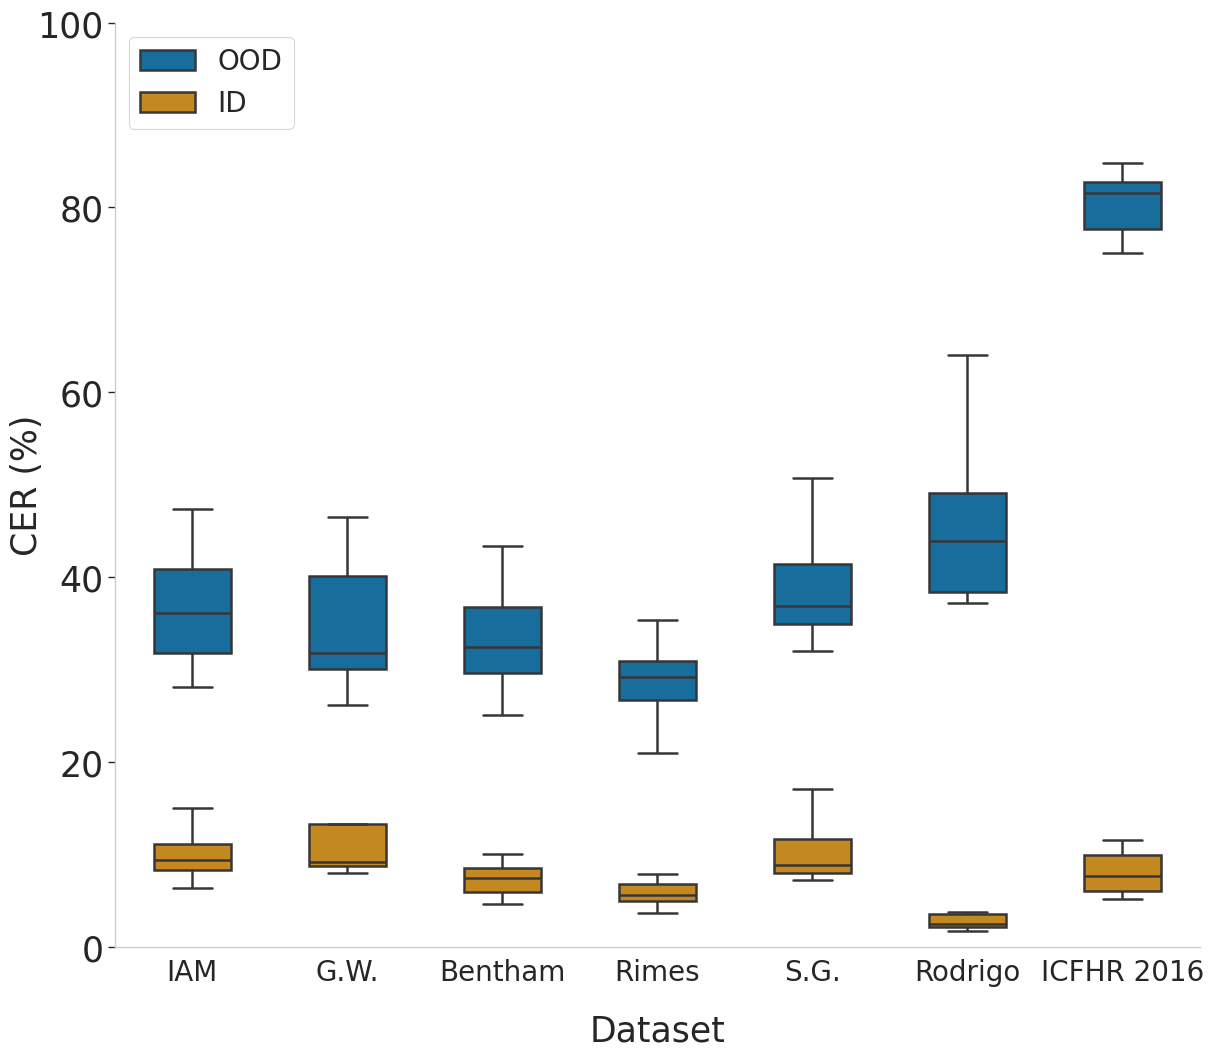

In [216]:
columns = ['Name', 'train_datasets', 'test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016']


# pd_all
# pd_all = pd.read_csv('../results/preliminary_results.csv')
pd_all = pd.read_csv('../results/results_all_final.csv')
pd_all = pd_all[columns]

pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_all['architecture'] = pd_all['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
# pd_all = pd_all.dropna()
pd_all = pd_all[['Name'] + ['architecture'] + columns[1:]]

# Melt the table to have each test/test_cer_{dataset} in a single column
pd_all = pd.melt(pd_all, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_all['test_dataset'] = pd_all['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)


# Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
pd_all['scenario'] = pd_all.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)

display(pd_all)

pd_all['CER'] = pd_all['CER'] * 100

# Cap the CER value to 100
pd_all['CER'] = pd_all['CER'].apply(lambda x: min(x, 100))

# Drop  if scenario is ID and CER > 40
pd_all = pd_all[~((pd_all['scenario'] == 'ID') & (pd_all['CER'] > 40))]

sns.set_context("paper")
# sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 1, figsize=(14, 12))

axs.set_ylim(0, 100)


# pd_all['CER'] = pd_all['CER'].apply(lambda x: min(x, 1)) * 100

# Filter to have per each test_dataset in OOD the best value 
pd_all = pd_all.groupby(['test_dataset', 'scenario', 'architecture']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)

# Select only the best OOD value for each test_dataset for each architecture
pd_all_ood = pd_all[pd_all['scenario'] == 'OOD']
pd_all_id = pd_all[pd_all['scenario'] == 'ID']

# Filter if ID CER > 30
pd_all_id = pd_all_id[~(pd_all_id['CER'] > 30)]

# Clamp if ID CER > 30 to 35
# pd_all_id['CER'] = pd_all_id['CER'].apply(lambda x: min(x, 25))

pd_all_ood = pd_all_ood.groupby(['test_dataset', 'architecture'], group_keys=True).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
display(pd_all_ood)

# Concatenate both tables
pd_all = pd.concat([pd_all_ood, pd_all_id])
pd_all = pd_all.reset_index(drop=True)




# Sort results according to the test_dataset: ['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016']
test_order = ['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016']

pd_all['test_dataset'] = pd.Categorical(pd_all['test_dataset'], categories=test_order, ordered=True)
pd_all = pd_all.sort_values('test_dataset')
# display(pd_all)



# Make the markers bigger
# Order the x axis as iam, washington, bentham, rimes, saint_gall, rodrigo, icfhr_2016 and change the labels to be capitalized
# sns.scatterplot(data=pd_all, x='test_dataset', y='CER', hue='architecture', style='scenario', ax=axs, s=75, palette='colorblind', markers=['o', 'X'], alpha=0.7, edgecolor='black')

# Make a whisker plot for each test_dataset averaging the CER value for each architecture and scenario. Make the boxplot one above the other between ID and OOD
sns.boxplot(data=pd_all, x='test_dataset', y='CER', hue='scenario', ax=axs, linewidth=1.8, dodge=False, width=0.5, palette='colorblind', hue_order=['OOD', 'ID'], showfliers=False)



handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# by_label.pop('ID')
# by_label.pop('OOD')
# by_label.pop('Scenario')
# by_label.pop('architecture')
axs.legend(by_label.values(), by_label.keys(), title='Scenario', loc='upper left', ncol=1, fontsize=20, title_fontsize=-1)
# Remove title from legend
axs.get_legend().set_title('')


axs.set_xticklabels(['IAM', 'G.W.', 'Bentham', 'Rimes', 'S.G.', 'Rodrigo', 'ICFHR 2016'])
# axs.set_yticks([0, 10, 30, 50, 70, 90, 100])
# axs.set_yticks(np.arange(0, 101, 10))
axs.set_yticks([0, 20, 40, 60, 80, 100], minor=True)
# Delete yticks for [30, 50, 70, 90]
# axs.set_yticks(np.arange(0, 101, 10), minor=True)
# Set yticks visible to the left
axs.yaxis.set_ticks_position('left')
# axs.xaxis.set_ticks_position('bottom')


axs.set_xlabel('Dataset', fontsize=25, labelpad=20)
axs.set_ylabel('CER (%)', fontsize=25, labelpad=-5)
# axs.set_title('CER for each test dataset', fontsize=30)


# Make y ticks bigger
plt.setp(axs.get_yticklabels(), fontsize=25)
plt.setp(axs.get_xticklabels(), fontsize=20)

# Invert boxplot colors


# Set the legend at the top and flatten horizontally just below the title


# Remove grid
axs.grid(False)

# Remove rectangle around the plot
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

# Save the figure in results with .pdf extension
plt.savefig('../results/ID_OOD.pdf', format='pdf', bbox_inches='tight')


## Model selection results

In [96]:
import pandas as pd
columns = ['Name', 'train_datasets', 'test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016']

# pd_all
pd_all = pd.read_csv('../results/results_all_final.csv')
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_all['architecture'] = pd_all['Name'].apply(lambda x: x.split('_src_')[0])
display(pd_all['architecture'].unique())

# Map arquitectures to beautify the names
architectures_names =  dict({
  'v_light_barrere': 'VLT', 'van_coquenet': 'VAN', 'transformer_kang': 'Kang', 'cnn_san_arce': 'C-SAN',
  'light_barrere': 'LT', 'htr_vit': 'HTR-VIT', 'crnn_puig': 'CRNN', 'crnn_michael': 'Michael'
})

pd_all['architecture'] = pd_all['architecture'].map(architectures_names)

# # Change crnn_puig to Puigcerver and van_coquenet to VAN Coquenet
# pd_all['architecture'] = pd_all['architecture'].apply(lambda x: 'Puigcerver' if x == 'crnn_puig' else 'VAN Coquenet')

# # Drop if any of the columns contains a NaN value
# # pd_all = pd_all.dropna()
pd_all = pd_all[['Name'] + ['architecture'] + columns[1:]]

# # Melt the table to have each test/test_cer_{dataset} in a single column
pd_all = pd.melt(pd_all, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_all['test_dataset'] = pd_all['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)
# Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
pd_all['scenario'] = pd_all.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)
pd_all['CER'] = pd_all['CER'] * 100

# Cap the CER value to 100
pd_all['CER'] = pd_all['CER'].apply(lambda x: min(x, 100))

display(pd_all)

array(['crnn_puig', 'transformer_kang', 'htr_vit', 'light_barrere',
       'van_coquenet', 'v_light_barrere', 'cnn_san_arce', 'crnn_michael'],
      dtype=object)

,Name,train_datasets,architecture,test_dataset,CER,scenario
0,crnn_puig_src_rimes_tgt_washington_test,rimes,CRNN,iam,36.493224,OOD
1,crnn_puig_src_rimes_tgt_saint_gall_test,rimes,CRNN,iam,36.944327,OOD
2,crnn_puig_src_rimes_tgt_rodrigo_test,rimes,CRNN,iam,36.944327,OOD
3,crnn_puig_src_rimes_tgt_icfhr_2016_test,rimes,CRNN,iam,35.833797,OOD
4,crnn_puig_src_rimes_tgt_iam_test,rimes,CRNN,iam,36.944327,OOD
...,...,...,...,...,...,...
4937,light_barrere_src_rimes_ID_test,rimes,LT,icfhr_2016,90.473449,OOD
4938,light_barrere_src_iam_optim_icfhr_2016_test,iam,LT,icfhr_2016,87.780333,OOD
4939,light_barrere_src_iam_optim_iam_test,iam,LT,icfhr_2016,98.059231,OOD
4940,light_barrere_src_iam_optim_bentham_test,iam,LT,icfhr_2016,94.263947,OOD


In [97]:
# Separate according to the scenario. if Name contains tgt: model_selection=oracle, if Name contains tgt: model_selection=heldout,  If Name does not contain any of the previous: model_selection=no-selection
pd_all['model_selection'] = pd_all['Name'].apply(lambda x: 'oracle' if 'optim' in x else 'heldout' if 'tgt' in x else 'no-selection')
display(pd_all)

,Name,train_datasets,architecture,test_dataset,CER,scenario,model_selection
0,crnn_puig_src_rimes_tgt_washington_test,rimes,CRNN,iam,36.493224,OOD,heldout
1,crnn_puig_src_rimes_tgt_saint_gall_test,rimes,CRNN,iam,36.944327,OOD,heldout
2,crnn_puig_src_rimes_tgt_rodrigo_test,rimes,CRNN,iam,36.944327,OOD,heldout
3,crnn_puig_src_rimes_tgt_icfhr_2016_test,rimes,CRNN,iam,35.833797,OOD,heldout
4,crnn_puig_src_rimes_tgt_iam_test,rimes,CRNN,iam,36.944327,OOD,heldout
...,...,...,...,...,...,...,...
4937,light_barrere_src_rimes_ID_test,rimes,LT,icfhr_2016,90.473449,OOD,no-selection
4938,light_barrere_src_iam_optim_icfhr_2016_test,iam,LT,icfhr_2016,87.780333,OOD,oracle
4939,light_barrere_src_iam_optim_iam_test,iam,LT,icfhr_2016,98.059231,OOD,oracle
4940,light_barrere_src_iam_optim_bentham_test,iam,LT,icfhr_2016,94.263947,OOD,oracle


In [98]:
# For each model selection, select the best OOD obtained for each test_dataset and architecture
pd_all_grouped = pd_all[pd_all['scenario'] == 'OOD'].groupby(['test_dataset', 'scenario', 'architecture', 'model_selection']).apply(lambda x: x.nsmallest(1, 'CER')).reset_index(drop=True)
pd_all_grouped

# # Get the average CER grouping by architecture and model_selection
pd_all_grouped_avg = pd_all_grouped.groupby(['architecture', 'model_selection']).mean().reset_index()
# pd_all_grouped_avg

# Get the relative difference between oracle and heldout with respect to no-selection
# pd_all_grouped_avg['relative_diff'] = pd_all_grouped_avg.groupby('architecture').apply(lambda x: x['CER'].diff().shift(-1)).reset_index(drop=True)
# pd_all_grouped_avg

# Convert each model selection to a column for each architecture
pd_all_grouped_avg = pd_all_grouped_avg.pivot(index='architecture', columns='model_selection', values='CER').reset_index()
pd_all_grouped_avg.columns = ['architecture', 'heldout', 'no-selection', 'oracle']
# pd_all_grouped_avg

# Add new architectures as rows called C-SAN-Arce, HTR-VIT, Kang, TrOCR, Michael, LT y VLT and add for each column a random with 0.001 to 0.01 for each column of model selection
# Add +0.0001 to the CER values
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['C-SAN-Arce', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['HTR-VIT', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['Kang', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['TrOCR', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['Michael', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['LT', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg.loc[len(pd_all_grouped_avg)] = ['VLT', pd_all_grouped_avg['heldout'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['no-selection'].mean() + np.random.normal(0, 0.01), pd_all_grouped_avg['oracle'].mean() + np.random.normal(0, 0.01)]
# pd_all_grouped_avg



/tmp/ipykernel_740466/3375768168.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_all_grouped_avg = pd_all_grouped.groupby(['architecture', 'model_selection']).mean().reset_index()


In [99]:
pd_all_grouped_avg

,architecture,heldout,no-selection,oracle
0,C-SAN,43.725153,44.808954,43.637009
1,CRNN,37.370700,38.493606,36.840830
2,HTR-VIT,39.814053,41.208213,39.140033
3,Kang,49.540905,51.777697,48.462502
4,LT,43.695036,45.060368,43.075232
5,Michael,53.253459,53.925140,52.974938
6,VAN,36.469878,37.426399,36.294320
7,VLT,42.726550,43.912387,42.482505


(30.0, 70.0)

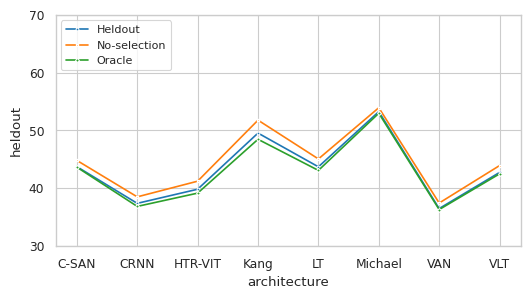

In [166]:
# Make a plot with 3 lines, one for each model selection, with the average CER for each architecture from pd_all_grouped_avg
sns.set_context("paper")
sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 1, figsize=(6, 3))

# Make the markers bigger
# Order the x axis as iam, washington, bentham, rimes, saint_gall, rodrigo, icfhr_2016 and change the labels to be capitalized

# Make a line plot for each model selection
sns.lineplot(data=pd_all_grouped_avg, x='architecture', y='heldout', ax=axs, marker='o', markersize=2, label='Heldout', color='tab:blue')
sns.lineplot(data=pd_all_grouped_avg, x='architecture', y='no-selection', ax=axs, marker='X', markersize=2, label='No-selection', color='tab:orange')
sns.lineplot(data=pd_all_grouped_avg, x='architecture', y='oracle', ax=axs, marker='D', markersize=2, label='Oracle', color='tab:green')

# Set the legend at the top and flatten horizontally just below the title
handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs.legend(by_label.values(), by_label.keys(), title='Model selection', loc='upper left', ncol=1, fontsize=8, title_fontsize=-1)
# Remove title from legend
axs.get_legend().set_title('')
axs.set_yticks(np.arange(0, 101, 10))
# axs.set_yticks([0, 10, 30, 50, 70, 90, 100])

axs.set_ylim(30, 70)



In [100]:
# Calculate the relative difference between oracle and heldout with respect to no-selection
pd_all_grouped_avg['relative_diff_oracle'] = (pd_all_grouped_avg['no-selection'] - pd_all_grouped_avg['oracle']) / pd_all_grouped_avg['oracle'] * 100 
pd_all_grouped_avg['relative_diff_heldout'] = (pd_all_grouped_avg['no-selection'] - pd_all_grouped_avg['heldout']) / pd_all_grouped_avg['heldout'] * 100

# Reformat the table to have the relative difference for each model selection (relative_diff_oracle and relative_diff_heldout) in a single column
pd_all_grouped_avg_melted = pd_all_grouped_avg.melt(id_vars='architecture', value_vars=['relative_diff_oracle', 'relative_diff_heldout'], var_name='model_selection', value_name='relative_diff')
display(pd_all_grouped_avg_melted)

# Rename the model_selection values eliminating the prefix relative_diff_
pd_all_grouped_avg_melted['model_selection'] = pd_all_grouped_avg_melted['model_selection'].apply(lambda x: x.removeprefix('relative_diff_'))


,architecture,model_selection,relative_diff
0,C-SAN,relative_diff_oracle,2.685668
1,CRNN,relative_diff_oracle,4.486262
2,HTR-VIT,relative_diff_oracle,5.284051
3,Kang,relative_diff_oracle,6.840742
4,LT,relative_diff_oracle,4.608532
5,Michael,relative_diff_oracle,1.793682
6,VAN,relative_diff_oracle,3.119164
7,VLT,relative_diff_oracle,3.365814
8,C-SAN,relative_diff_heldout,2.478666
9,CRNN,relative_diff_heldout,3.004776


/tmp/ipykernel_740466/801657838.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/tmp/ipykernel_740466/801657838.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)


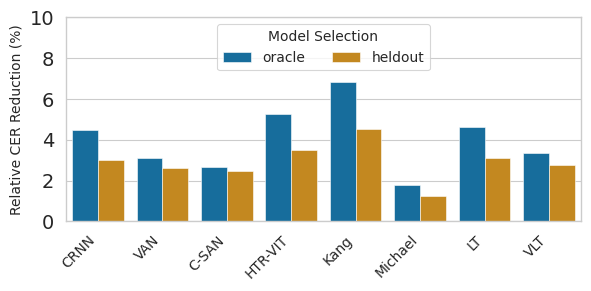

In [101]:
# Make a plot with the average CER for each architecture and model_selection
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Set the y-axis limit
ax.set_ylim(0, 10)

# Create the bar plot with 'architecture' on x-axis and 'relative_diff' on y-axis, hue by 'model_selection'

# Change x order to: ['CRNN', 'VAN', 'C-SAN', 'HTR_VIT', 'Kang', 'Michael', 'LT', 'VLT']
pd_all_grouped_avg_melted['architecture'] = pd.Categorical(pd_all_grouped_avg_melted['architecture'], categories=['CRNN', 'VAN', 'C-SAN', 'HTR-VIT', 'Kang', 'Michael', 'LT', 'VLT'], ordered=True)
sns.barplot(data=pd_all_grouped_avg_melted, x='architecture', y='relative_diff', hue='model_selection', ax=ax, palette='colorblind', linewidth=0.4) 


# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

# Set axis labels and title
# ax.set_xlabel("Architecture", fontsize=12)
# Remove x label
ax.set_xlabel('')
ax.set_ylabel("Relative CER Reduction (%)", fontsize=10)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)
# ax.set_title("Average CER Reduction by Architecture and Model Selection", fontsize=14)

# Adjust the legend position and title
ax.legend(title="Model Selection", loc='upper center', fontsize=10, ncols=2, title_fontsize=10)

# Add tight layout for better spacing
plt.tight_layout()

# Save the figure in results with .pdf extension
plt.savefig('../results/model_selection.pdf', format='pdf', bbox_inches='tight')


In [120]:
pd_all_grouped_avg_params

,architecture,heldout,no-selection,oracle,relative_diff_oracle,relative_diff_heldout,n_parameters,CER
1,CRNN,37.370700,38.493606,36.840830,4.486262,3.004776,9.6,38.493606
6,VAN,36.469878,37.426399,36.294320,3.119164,2.622771,2.7,37.426399
0,C-SAN,43.725153,44.808954,43.637009,2.685668,2.478666,1.7,44.808954
2,HTR-VIT,39.814053,41.208213,39.140033,5.284051,3.501678,53.5,41.208213
3,Kang,49.540905,51.777697,48.462502,6.840742,4.515042,90.0,51.777697
5,Michael,53.253459,53.925140,52.974938,1.793682,1.261291,5.0,53.925140
4,LT,43.695036,45.060368,43.075232,4.608532,3.124686,7.7,45.060368
7,VLT,42.726550,43.912387,42.482505,3.365814,2.775412,5.6,43.912387


/tmp/ipykernel_740466/4141309455.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
/tmp/ipykernel_740466/4141309455.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle')
/tmp/ipykernel_740466/4141309455.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout')
/tmp/ipykernel_740466/4141309455.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()],

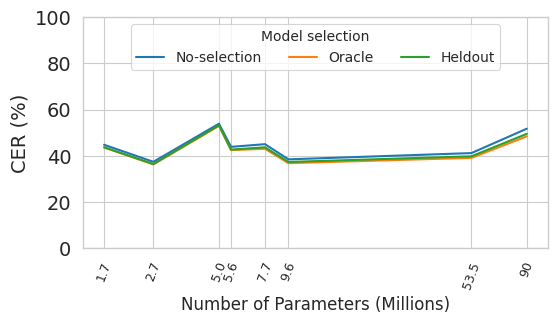

In [214]:
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Set the y-axis limit
ax.set_ylim(0, 100)

pd_all_grouped_avg_params = pd_all_grouped_avg.copy()
pd_all_grouped_avg_params['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
# pd_all_grouped_avg_params

# Make a line plot with the average CER for each architecture sorted by number of parameters
pd_all_grouped_avg_params = pd_all_grouped_avg_params.sort_values('n_parameters')
# pd_all_grouped_avg_params['CER'] = pd_all_grouped_avg_params['no-selection']

sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='no-selection', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='No-selection')
sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='oracle', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Oracle')
sns.lineplot(data=pd_all_grouped_avg_params, x='n_parameters', y='heldout', ax=ax, markersize=5, palette='colorblind', linewidth=1.5, label='Heldout')

# ax.set_ylim(30, 65)
# ax.set_yticks([30, 40, 50, 60])

ax.set_xscale('log')

ax.set_xticks([1.7, 2.7, 5, 5.6, 7.7, 9.6, 53.5, 90])
ax.set_xticklabels(['1.7', '2.7', '5.0', '5.6', '7.7', '9.6', '53.5', '90'], fontsize=9, rotation=70)

# ax.set_xticks([1.7, 3, 5, 7, 10, 50, 90])
# ax.set_xticklabels(['1.7', '3', '5', '7', '10', '50', '90'], fontsize=9, rotation=0)

# Write every parameter as text
# for i, txt in enumerate(pd_all_grouped_avg_params['architecture']):
#     ax.annotate(txt, (pd_all_grouped_avg_params['n_parameters'][i], pd_all_grouped_avg_params['no-selection'][i]), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=9)

# Set axis labels and title
ax.set_xlabel("Number of Parameters (Millions)", fontsize=12)
ax.set_ylabel("CER (%)", fontsize=14)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)

# Set legend
# ax.legend(title="Model Selection", loc='upper center', fontsize=10, title_fontsize=10)
# legend_labels = ['No-selection', 'Oracle', 'Heldout']
# colors = sns.color_palette('colorblind')
ax.legend(title="Model selection", loc='upper center', fontsize=10, title_fontsize=10, ncol=3)

# Save the figure in results with .pdf extension
plt.savefig('../results/parameters_2.pdf', format='pdf', bbox_inches='tight')








,architecture,model_selection,relative_diff,n_parameters
0,C-SAN,oracle,2.685668,1.7
1,CRNN,oracle,4.486262,9.6
2,HTR-VIT,oracle,5.284051,53.5
3,Kang,oracle,6.840742,90.0
4,LT,oracle,4.608532,7.7
5,Michael,oracle,1.793682,5.0
6,VAN,oracle,3.119164,2.7
7,VLT,oracle,3.365814,5.6
8,C-SAN,heldout,2.478666,1.7
9,CRNN,heldout,3.004776,9.6


/tmp/ipykernel_740466/520822356.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)


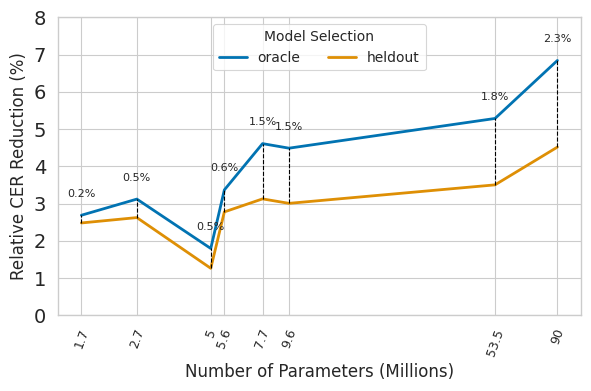

In [161]:
# Add the following number of parameters to each architecture: 
# Puigcerver: 9.6M, VAN Coquenet: 2.7M, C-SAN-Arce: 1.7M, HTR-VIT: 53.5M, Kang: 90M, TrOCR: 62M, Michael: 8M, LT: 7.7M, VLT: 5.6M as float
pd_all_grouped_avg_melted['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'CRNN' else 2.7 if x == 'VAN' else 1.7 if x == 'C-SAN' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 5 if x == 'Michael' else 7.7 if x == 'LT' else 5.6 if x == 'VLT' else 0.0)
display(pd_all_grouped_avg_melted)

# Make a plot with the average CER for each model selection and number of parameters in the x-axis
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Set the y-axis limit
ax.set_ylim(0, 8)

# Create a line plot with 'n_parameters' on x-axis and 'relative_diff' on y-axis, hue by 'model_selection'
sns.lineplot(data=pd_all_grouped_avg_melted, x='n_parameters', y='relative_diff', hue='model_selection', ax=ax, palette='colorblind', linewidth=2)

# Set the x axis to other scale
ax.set_xscale('log')

ax.set_xticks([1.7, 2.7, 5, 5.6, 7.7, 9.6, 53.5, 90])
ax.set_xticklabels(['1.7', '2.7', '5', '5.6', '7.7', '9.6', '53.5', '90'], fontsize=9, rotation=70)

# Make a vertical line measuring the absolute difference between oracle and heldout with respect to no-selection with annotated difference in each point
for i, row in pd_all_grouped_avg_params.iterrows():
  diff = row['relative_diff_oracle'] - row['relative_diff_heldout']
  ax.plot([row['n_parameters'], row['n_parameters']], [row['relative_diff_heldout'], row['relative_diff_oracle']], linestyle='--', color='black', linewidth=0.8)
  ax.text(row['n_parameters'], row['relative_diff_oracle'] + 0.5, f"{np.round(diff, 1):.1f}%", fontsize=8, ha='center')
  
  
    

# Add text to the vertical line


# Set axis labels and title
ax.set_xlabel("Number of Parameters (Millions)", fontsize=12)
ax.set_ylabel("Relative CER Reduction (%)", fontsize=12)


ax.set_ylabel("Relative CER Reduction (%)", fontsize=12)
ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()], fontsize=14)

# Adjust the legend position and title
# ax.legend(title="Model Selection", loc='upper center', fontsize=10, title_fontsize=10)
ax.legend(title="Model Selection", loc='upper center', fontsize=10, ncols=2, title_fontsize=10)

# make a legend for vertical line
# ax.plot([], [], linestyle='--', color='black', linewidth=0.8, label='|Oracle - Heldout|')
# ax.legend(title="Model Selection", loc='upper center', fontsize=10, ncols=2, title_fontsize=10)

# Add tight layout for better spacing
plt.tight_layout()

# Save the figure in results with .pdf extension
plt.savefig('../results/parameters.pdf', format='pdf', bbox_inches='tight')
